<a href="https://colab.research.google.com/github/QuantumQist/PyTorch-klasyfikacja_liczb/blob/main/MNIST_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
import torch, torchvision
from torch import nn

import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# PyTorch - klasyfikacja MNIST

# 1. Załadowanie danych

## 1.1. Datasety

In [48]:
train_dataset = torchvision.datasets.MNIST(
    root = "data",
    download = True,
    train = True,
    transform = torchvision.transforms.ToTensor()
)

test_dataset = torchvision.datasets.MNIST(
    root = "data",
    download = True,
    train = False,
    transform = torchvision.transforms.ToTensor()
)

## 1.2. Elementy datasetów

4

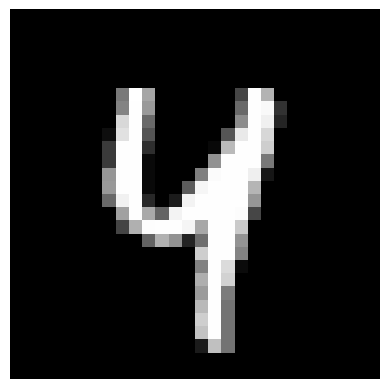

In [49]:
IDX = 42

image, label = test_dataset[42]

plt.imshow(image.squeeze().numpy(), cmap = "gray")
plt.axis(False)

label

## 1.3. DataLoader

In [50]:
BATCH_SIZE = 64

train_dataloader = torch.utils.data.DataLoader(
    dataset = train_dataset,
    batch_size = BATCH_SIZE,
    shuffle = True,
    drop_last = True
)
test_dataloader = torch.utils.data.DataLoader(
    dataset = test_dataset,
    batch_size = BATCH_SIZE,
    shuffle = True,
    drop_last = True
)

### 1.4. Elementy DataLoaderów

In [51]:
dataloader_element = next(iter(train_dataloader))

dataloader_element[0].shape

torch.Size([64, 1, 28, 28])

# 2. Sieć neuronowa

## 2.1. Postawienie sieci

In [52]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100,10)
)

## 2.2. Dummy forward pass

In [53]:
image, _ = test_dataset[52]
image = image.unsqueeze(dim=0)
print(f"Input shape: {image.shape}\n---------")
with torch.inference_mode():
    model_output = model(image)
print(f"Model output shape: {model_output.shape}")

softmax_layer = nn.Softmax(dim = -1)
output = softmax_layer(model_output)

torch.sum(output)


Input shape: torch.Size([1, 1, 28, 28])
---------
Model output shape: torch.Size([1, 10])


tensor(1.0000)

In [54]:
model_output

tensor([[ 0.0219,  0.0566, -0.0609,  0.1209, -0.0968,  0.0180, -0.1218,  0.0683,
         -0.0797, -0.1171]])

## 2.3. Ewaluacja sieci.

In [83]:
def get_accuracy(
        model: nn.Module,
        dataset: torch.utils.data.Dataset):
    """
    Computes model accuracy on a given dataset
    """
    correct_preds = 0

    model.eval()

    for element in dataset:
        # Get feature and label
        X, y = element
        X = X.unsqueeze(dim = 0)
        # Get prediction
        with torch.inference_mode():
            y_logits = model(X)
        # Get maximum element
        prediction = torch.argmax(y_logits, dim = -1 ).item()
        if prediction == y:
            correct_preds += 1

    return correct_preds / len(dataset)

In [56]:
acc = get_accuracy(
    model = model,
    dataset = test_dataset
)
acc

0.1008

# 3. Pętla treningowa

## 3.1. Funkcja strat (*criterion*) i optimizer.



In [57]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam( model.parameters() )

## 3.2. Funkcja definiująca pętlę treningową.

In [74]:
def train_model(epochs: int,
                model: nn.Module,
                train_dataloader: torch.utils.data.DataLoader,
                test_dataloader: torch.utils.data.DataLoader,
                loss_fn: nn.Module,
                optimizer: torch.optim.Optimizer):

    train_loss_list, test_loss_list = [], []

    # Loop over epochs
    for epoch in tqdm(range(epochs)):

        ### Training step
        model.train()
        # Loop over batch
        train_loss = 0
        for batch, (X, y) in enumerate(train_dataloader):
            # Forward pass
            y_logits = model(X)
            # Calculate the loss
            loss = loss_fn(y_logits, y)
            train_loss += loss.item()
            # Zero gradients
            optimizer.zero_grad()
            # Backpropagation
            loss.backward()
            # Optimizer step
            optimizer.step()

        ### Testing step
        model.eval()

        test_loss = 0
        # Loop over batches
        for batch, (X, y) in enumerate(test_dataloader):
            # Forward pass
            with torch.inference_mode():
                y_logits = model(X)
            # Calculate the loss
            loss = loss_fn(y_logits, y).item()
            test_loss += loss

        train_loss_list.append( train_loss / len(train_dataloader) )
        test_loss_list.append( test_loss / len(test_dataloader) )

    return {"train_loss": train_loss_list, "test_loss": test_loss_list}

In [75]:
len(train_dataloader), len(test_dataloader)

(937, 156)

## 3.3. Trening sieci

In [79]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 50),
    nn.ReLU(),
    nn.Linear(50, 50),
    nn.ReLU(),
    nn.Linear(50,10)
)

optimizer = torch.optim.Adam( model.parameters() )

In [80]:
EPOCHS = 10

results = train_model(
    epochs = EPOCHS,
    model = model,
    train_dataloader = train_dataloader,
    test_dataloader = test_dataloader,
    optimizer = optimizer,
    loss_fn = loss_fn
)

  0%|          | 0/10 [00:00<?, ?it/s]

## 3.4. Ewaluacja treningu - loss function

Text(0.5, 0, 'Epoka')

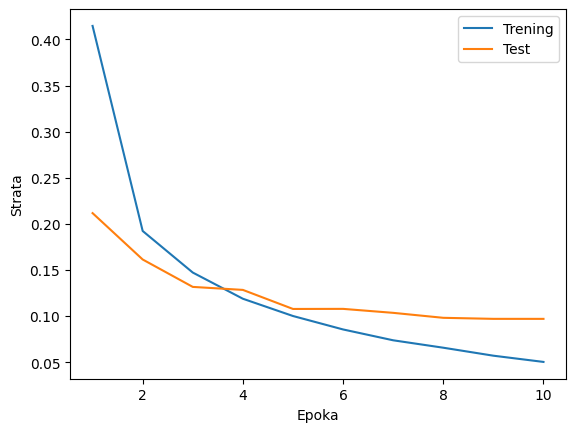

In [81]:
plt.plot(range(1, EPOCHS + 1), results["train_loss"], label = "Trening")
plt.plot(range(1, EPOCHS + 1), results["test_loss"], label = "Test")
plt.legend()
plt.ylabel("Strata")
plt.xlabel("Epoka")

# 4. Ocena wytrenowanego modelu.



## 4.1. Przewidywania na pojedynczym zdjęciu

Text(0.5, 1.0, 'Predicition: 6')

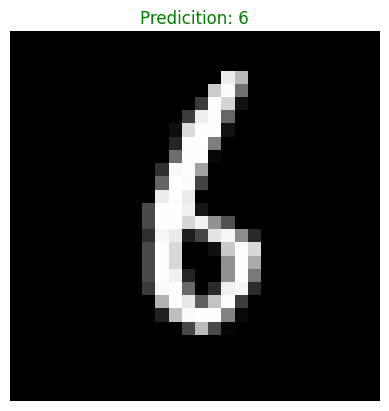

In [95]:
RANDOM_IDX = np.random.randint(0, len(test_dataset))
# Get image and label
image, label = test_dataset[RANDOM_IDX]
image.unsqueeze(dim = 0)
# Forward pass
model.eval()
with torch.inference_mode():
    y_logits = model(image)
# Prediction
prediction = torch.argmax(y_logits, dim = -1).item()

image = image.squeeze().numpy()
plt.imshow(image, cmap = 'gray')
plt.axis(False)
# Check if the prediciton is correct
if prediction == label:
    color = "green"
else:
    color = "red"
plt.title(f"Predicition: {prediction}", color = color)

### 4.2. Dokładność (accuracy) na pełnych danych testowych.

In [84]:
acc_train = get_accuracy(
    model = model,
    dataset = train_dataset
)
acc_test = get_accuracy(
    model = model,
    dataset = test_dataset
)

Training data accuracy: 0.9858333333333333
Testing data accuracy:  0.9724


In [85]:
print(f"Training data accuracy: {acc_train:.2f}")
print(f"Testing data accuracy:  {acc_test:.2f}")

Training data accuracy: 0.99
Testing data accuracy:  0.97
